In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

# Question 1

First, let's implement a binomial tree for the asset (FX rate)

In [2]:
def binomial_tree(S0, nu, N):
    """"" Binomial tree for an asset with initial spot price S0 over N periods.
    nu determines how the price goes up or down on the tree: S[j] -> ((1+ nu) S[j], (1-nu)S[j]) """
    return [[S0*(1+nu)**(j-i)*(1-nu)**i for i in range(j+1)] for j in range(N+1)]

In [3]:
#Example
tree = binomial_tree(S0 = 1, nu = 0.05, N = 2)
for branch in tree:
    print(branch)
del(tree)

[1.0]
[1.05, 0.95]
[1.1025, 0.9974999999999999, 0.9025]


Let's price a European put option on a binomial tree

In [4]:
def opt_E_put(S0, nu, N, K):
    """Price of a European put option on a binomial tree.
    S0 is the initial spot price of the underlying.
    N is the number of periods until the option matures.
    nu determines how the price of the underlying goes up or down: S[j] -> ((1+ nu) S[j], (1-nu)S[j]).
    K is the strike price at maturity."""
    
    #start by pricing the option at maturity.
    
    tree = [[ max(K- S0*(1+nu)**(N-i)*(1-nu)**i, 0) for i in range(N+1)]]
    
    # use risk neutral probabilities to calculate the price before maturity
    # risk neutral probabilities are 1/2
    
    curr = tree[0] 
    l = N+1 #branch of the tree
    while l > 1:
        nex = [0.5*curr[i]+0.5*curr[i+1] for i in range(l-1)]
        tree.append(nex)
        curr = nex
        l -=1
    tree.reverse()
    return tree[0][0]

In [5]:
#Example
S0 = 1.28065
nu = 0.05
N =2
K = 1.28065
print(opt_E_put(S0, nu, N, K))
del(S0,nu,N,K)

0.03281665625000002


# Question 2

Before directly answering the question, let's plot the value V of an option as a function of the parameter nu 

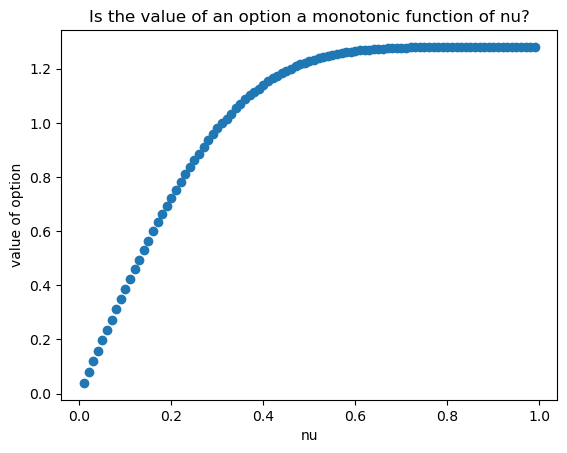

In [24]:
S0 = 1.28065
N = 60
K = 1.28065
nus = [0.01*i for i in range(1,100)] # list of nu, for plotting
values = [opt_E_put(S0, nu, N, K) for nu in nus] # list of values, for plotting
plt.plot(nus, values, "o")  
plt.xlabel('nu')  
plt.ylabel('value of option')
plt.title('Is the value of an option a monotonic function of nu?')  
plt.show() 
del(S0,nus,values,K,N)

So, we want to solve the equation V_option(nu) = V, where V is the market value of the option. We know that this equation has a solution because the plot above implies that V_option(nu) is bijective.

We will apply the Newton-Raphson method to numerically solve these equations.

In [7]:
def cal_opt_E_put(S0, N, K, V, nu_0 = 0.05, max_iter = 10**3, delta_nu = 0.01):
    """Function that calibrates the parameter nu of a European put option.
        
    S0 is the spot price of the underlying at time t=0.
    N is the number of periods until maturity of the option.
    K is the strike price.
    V is the market value of the option at t=0.
    
    This function employs the Newton-Raphson numerical method.
    nu_0 is the initial guess for nu.
    max_iter is the maximum number of iterations allowed in Newton-Raphson.
    delta_nu is a parameter to evaluate derivatives in Newton-Raphson.
    (smaller delta_nu makes the algorithm slower but more likely to converge)
    """
    
    error = abs(opt_E_put(S0, nu_0, N, K) - V)
    threshold  = 10**(-5) * V #precision we set
    i = 0 #number of interations of Newton-Raphson
    
    while error > threshold and i < max_iter:
        derivative = (opt_E_put(S0, nu_0 + delta_nu, N, K) - opt_E_put(S0, nu_0, N, K))/delta_nu
        nu_0 = nu_0 - (opt_E_put(S0, nu_0, N, K) -V )/ derivative #update nu_0
        error = abs(opt_E_put(S0, nu_0, N, K) - V) #recompute error
        i +=1
        print('number of iterations is ' + str(i))
    
    if error < threshold:
        print('Algorithm converged! '+' nu is equal to '+str(round(nu_0,3)))
        return nu_0
    else:
        print('Algorithm failed to converge. Change the settings of nu_0, max_iter or delta_nu.')    

In [8]:
#Example
S0 = 1.28065
N = 12
K= S0
V = 0.2 # value of the option
nu = cal_opt_E_put(S0, N, K, V)
del(S0,N,K,V,nu)

number of iterations is 1
number of iterations is 2
Algorithm converged!  nu is equal to 0.112


# Question 3

In [9]:
def max_tree(S0, nu, N, M = 10**4):
    """"Function that simulates the paths taken by an asset price (stochastic)
    on a binomial tree and calculates the sample mean of the maximum value 
    that it takes along a path.
    
    S0 is the initial spot price of the asset.
    N is the number of periods we consider.
    nu determines how the price goes up or down on the tree: S[j] -> ((1+ nu) S[j], (1-nu)S[j]) 
    M is the total number of paths we simulate
    """
    

    tree = binomial_tree(S0, nu, N)
    maxs = [] #list of maximum values the asset takes along each trajectory
            
    for n in range(M): 
        maxi = tree[0][0] #maximum for this simulation
        curr = tree[0][0] #current value, as we traverse the tree
        j = 0 #height along a branch
        for i in range(1, N+1): #i denotes the branch that we're in
            #flip a coin and determine whether we increase the height or not
            if np.random.rand() < 0.5:
                pass
            else:
                j += 1
            curr = tree[i][j]
            if curr > maxi:
                maxi = curr
        maxs.append(maxi) #we store the new maximum obtained in this trajectory
         
    return sum(maxs)/len(maxs) #sample mean

In [10]:
#Example
S0 = 1.28065
nu = 0.05
N = 10
print(max_tree(S0, nu, N))
del(S0,nu,N)

1.4178954269638135


# Question 4

First, let's import the file from excel to python

In [11]:
df = pd.read_excel('Quantitative_Analyst_Case_Study_2024_Cashflow_Model.xlsx')
df

,Time,Fund,Cashflow Type,Cashflow Amount (in Local Asset Currecny),Local Asset Currency,Fund Currency,Base Case IRR
0,2024-03-31,Validus V,Equity,-100000000,GBP,USD,0.149925
1,2025-03-31,Validus V,Proceeds,15000000,GBP,USD,NaN
2,2026-03-31,Validus V,Proceeds,15000000,GBP,USD,NaN
3,2027-03-31,Validus V,Proceeds,15000000,GBP,USD,NaN
4,2028-03-31,Validus V,Proceeds,15000000,GBP,USD,NaN
5,2029-03-31,Validus V,Proceeds,115000000,GBP,USD,NaN


In the table above, the cashflows happen yearly, whereas in our binomial model each period lasts 6 months. Thus, the table of cashflows per period in GBP is equal to:

In [12]:
annual_cashflow_GBP = df['Cashflow Amount (in Local Asset Currecny)'].to_numpy()
print(annual_cashflow_GBP)
bi_annual_cashflow_GBP = [annual_cashflow_GBP[i//2] if i%2==0 else 0 for i in range(11)]
print(bi_annual_cashflow_GBP)

[-100000000   15000000   15000000   15000000   15000000  115000000]
[-100000000, 0, 15000000, 0, 15000000, 0, 15000000, 0, 15000000, 0, 115000000]


Now let's write a function that determines the internal rate of return of a given cashflow. The function is agnostic about the currency. We will once again use Newton-Raphson to numerically solve an equation.

In [13]:
def irr(cashflow):
    """Function that determines the internal rate of return given a cashflow.
    It is agnostic about the currency.
    """
    
    def aux(cashflow, int_rate_return):
        #Auxiliary function, where we put the internal rate of return formula
        return sum(cashflow[i]/(1+int_rate_return)**i for i in range(len(cashflow)))
    
    int_rate_return = 0.1 #initial guess for irr
    delta_int_rate_return = 10**(-2) #parameter in newton-raphson
    error = abs(aux(cashflow, int_rate_return))  #error that we will minimize
    threshold = 1 #threshold to stop the algorithm
    i = 0 #number of iterations of Newton-Raphson
    
    while error > threshold:
        derivative = (aux(cashflow, int_rate_return + delta_int_rate_return) - aux(cashflow, int_rate_return))/delta_int_rate_return
        #update internal rate of return
        int_rate_return = int_rate_return - aux(cashflow, int_rate_return)/derivative
        error = abs(aux(cashflow, int_rate_return))
        i +=1
    
    if error < threshold:
        return int_rate_return
    else:
        print('There was a problem. Check whether the inputs make sense as cashflows.')      

In [14]:
#Example
print(irr(annual_cashflow_GBP)) #this mathes the base case in the excel file

0.1499999992056431


Finally, let us construct a function that simulates the FX spot rate paths, determines the associated cashflows in USD and computes the internal rate of return for each path.

In [15]:
def irr_fx(bi_annual_cashflow_GBP, S0 = 1.28065, nu = 0.05, M = 10**4):
    """Function that simulates the FX GBPUSD spot rate paths in a binomial tree, 
    determines the biannual cashflows in USD given a biannual cashflow in GBP
    and computes the internal rate of return for each path.
    
    bi_annual_cashflow_GBP is the bi annual cashflow in GBP
    S0 is the initial FX spot rate
    nu is a parameter in the binomial tree, that determines how the spot prices evolve
    M is the number of paths we will sample
    """
    N = len(bi_annual_cashflow_GBP)-1 #number of periods in the binomial tree
    tree = binomial_tree(S0, nu, N)
    irr_list = [] #list of internal rates of return we will calculate
        
    for ind in range(M):
        spot_path = [tree[0][0]] # spot path
        #traverse the tree
        j = 0 #height of the tree
        for i in range(1, N+1):
            if np.random.rand() < 0.5:
                pass
            else:
                j += 1
            spot_path.append(tree[i][j])
        #GBP to USD conversion:
        bi_annual_cashflow_USD = np.array(bi_annual_cashflow_GBP)*np.array(spot_path)  
        annual_cashflow_USD = [bi_annual_cashflow_USD[2*i] for i in range(N//2+1)]
        irr_list.append(irr(annual_cashflow_USD)) #compute internal rate of return
    return irr_list         

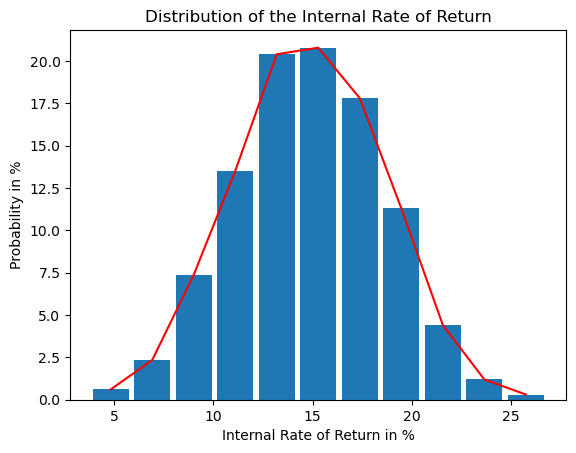

In [16]:
# calculation of list of internal rate of returns over M paths simulated 
irr_list = irr_fx(bi_annual_cashflow_GBP, S0 = 1.28065, nu = 0.05, M = 7*10**4)

#histogram

n_bins = int(round((max(irr_list)-min(irr_list))/0.02,0))
hist, bin_edges = np.histogram(irr_list, bins=n_bins, density=False)
frequencies = hist/len(irr_list)*100
bin_centers = [100*(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
plt.bar(bin_centers, frequencies, width=1.8, align='center')
plt.xlabel('Internal Rate of Return in %')  
plt.ylabel('Probability in %')
plt.title('Distribution of the Internal Rate of Return')
plt.plot(bin_centers, frequencies, 'r')
plt.show() 
del(n_bins, hist, bin_edges, frequencies, bin_centers)

# Question 5

The options's premium is equal to the notional amount times the premium of the option to exchange one pound over the same maturity.

In [17]:
S0 = 1.28065
N = 10
nu = 0.05
K = S0
notional_amount = 10**8
premium = opt_E_put(S0, nu, N, K)* notional_amount
print(premium)
del(S0, N, nu, K, notional_amount)

8048787.275357058


So, the european put option is worth around 8 million dollars at time t = 0.

# Question 6

We need to modify our calculation of the internal rate of return in question 4 in two ways:

1) the cashflow at t = 0 is changed by paying a premium for the option

2) the cashflow at t = 5 years is changed by the possibility of exercising the European put option.

In practice we simply calculate the cashflow associated to the option and add it to the previous calculated cashflow.

In [18]:
def irr_modified_fx(bi_annual_cashflow_GBP, S0 = 1.28065, nu = 0.05, M = 10**4, 
                    premium = 8048787.27535, notional_amount = 10**8):
    """Function that simulates the FX GBPUSD spot rate paths in a binomial tree, 
    determines the biannual cashflows in USD given a biannual cashflow in GBP
    and computes the internal rate of return for each path.
    
    It includes the cashflow associated to the European put option
    described earlier.
        
    bi_annual_cashflow_GBP is the bi annual cashflow in GBP
    S0 is the initial FX spot rate
    nu is a parameter in the binomial tree, that determines how the spot prices evolve
    M is the number of paths we will sample
    
    premium is the price paid for the option at t = 0
    notional_amount is the amount of pounds we will exchange at t = 5 years at the 
    t = 0 rate in case we exercise the option
    """
    N = len(bi_annual_cashflow_GBP)-1 #number of periods in the binomial tree
    tree = binomial_tree(S0, nu, N)
    irr_list = [] #list of internal rates of return we will calculate
    
    #biannual cashflow associated to the option in USD
    bi_annual_cashflow_opt_USD = [- premium] + [0 for i in range(N)]
    # we will modify the last entry of the option cashflow for each path
        
    for ind in range(M):
        spot_path = [tree[0][0]] # spot path
        #traverse the tree
        j = 0 #height of the tree
        for i in range(1, N+1):
            if np.random.rand() < 0.5:
                pass
            else:
                j += 1
            spot_path.append(tree[i][j])
        #cashflow option    
        bi_annual_cashflow_opt_USD[-1] = notional_amount * max(S0 - spot_path[-1], 0)
        #GBP to USD conversion:
        bi_annual_cashflow_USD = np.array(bi_annual_cashflow_GBP)*np.array(spot_path)
        bi_annual_cashflow_USD = bi_annual_cashflow_USD + bi_annual_cashflow_opt_USD
        annual_cashflow_USD = [bi_annual_cashflow_USD[2*i] for i in range(N//2+1)]
        irr_list.append(irr(annual_cashflow_USD)) #compute internal rate of return
    return irr_list         

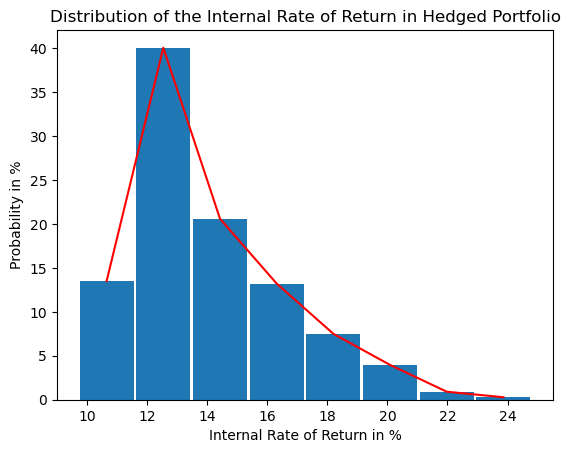

In [19]:
# calculation of list of internal rate of returns over M paths simulated 
irr_list_hed = irr_modified_fx(bi_annual_cashflow_GBP, S0 = 1.28065, nu = 0.05, M = 7*10**4)

#histogram

n_bins = int(round((max(irr_list_hed)-min(irr_list_hed))/0.02,0))
hist, bin_edges = np.histogram(irr_list_hed, bins=n_bins, density=False)
frequencies = hist/len(irr_list_hed)*100
bin_centers = [100*(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
plt.bar(bin_centers, frequencies, width=1.8, align='center')
plt.xlabel('Internal Rate of Return in %')  
plt.ylabel('Probability in %')
plt.title('Distribution of the Internal Rate of Return in Hedged Portfolio')
plt.plot(bin_centers, frequencies, 'r')
plt.show() 
del(n_bins, hist, bin_edges, frequencies, bin_centers)

We conclude that hedging the portfolio decreases the variance of the internal rate of return. It thus allow to decrease the risk, which is a positive outcome.

In [20]:
print(np.array(irr_list).mean() )
print(np.array(irr_list_hed).mean() )
print(np.array(irr_list).var() )
print(np.array(irr_list_hed).var() )

#percentate of improvement in variance
print((np.array(irr_list).var() - np.array(irr_list_hed).var())/np.array(irr_list).var() )

0.14803698129226858
0.14028308310223614
0.0013647504823395694
0.0006518471458644196
0.5223689939665976


The expected internal rate of return is roughly the same in the hedged and non-hedged portfolio, but the variance in the hedged portfolio is lower by 52%.